# Разработка стратегии удержания клиентов для фитнес-центов «Культурист-датасаентист».


### Описание проекта 

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.

Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. 
Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. 
**Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.**

**А именно:**
1. научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
2. сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
3. проанализировать основные признаки, наиболее сильно влияющие на отток;
4. сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
   - выделить целевые группы клиентов;
   - предложить меры по снижению оттока;
   - определить другие особенности взаимодействия с клиентами.
   
#### Описание данных
   
«Культурист-датасаентист» предоставил сведения в csv-файлах. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:

**Данные клиента за предыдущий до проверки факта оттока месяц:**
- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

**Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:**
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- 'Churn' — факт оттока в текущем месяце.


**Путь к файлу: /datasets/gym_churn.csv.**

#### Ход работы:
1. Изучение общей информации о данных;
2. Предобработка данных;
3. Исследовательский анализ данных (EDA);
4. Прогнозирование оттока клиентов;
5. Кластеризация клиентов;
6. Итоговые выводы и рекомендации.

### Изучение общей информации о данных.

In [1]:
#проигнорируем предупреждения
import warnings
warnings.filterwarnings('ignore')

In [2]:
#импорт библиотек 
import pandas as pd
import matplotlib.pyplot as plt 
from scipy import stats as st
import plotly.express as px  
import seaborn as sns 
from plotly import graph_objects as go
import math 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
import itertools
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [3]:
# чтение файла с данными и сохранение в gym
gym = pd.read_csv('/datasets/gym_churn.csv')
gym.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
# получение общей информации о данных в таблице 
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [5]:
#посчитаем явные дубликаты 
gym.duplicated().sum()

0

#### Выводы: 
1. Нарушен стиль в названиях столбцов - укажем все названия строчными буквами. 
2. Данные представлены в типах целых и вещественных чисел. 
3. Пропусков нет. 
4. Явные дубликаты не обнаружены.

### Предобработка данных.

In [6]:
# приведем заголовки столбцов к нижнему регистру 
gym.columns = gym.columns.str.lower()
gym.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


**Итак, данные готовы к дальнейшему анализу.** 

### Исследовательский анализ данных (EDA).

#### Посмотрите на датасет: есть ли в нем отсутствующие признаки, изучите средние значения и стандартные отклонения (пригодится метод describe());

In [7]:
gym.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


**Вывод:** 
1. Отсутствующих признаков в датасете нет. Всего 4000 записей. 
2. Мужчин и женщин примерно поравну. 
3. У 85% посетителей рядом находится дом или работа. 
4. Примерно половина клиентов являются сотрудниками компаний-партнёров клуба.
5. 30% использовали промо-код от знакомого при оплате первого абонемента.
6. Почти все клиенты указали номер телефона. 
7. Средняя длительность текущего действующего абонемента - 5 месяцев. 
8. Меньше половины клиентов посещают групповые занятия. 
9. Средний возраст клиентов 29 лет. Стандартное отклонение в 3 года. 
10. Средняя суммарная выручка от других услуг фитнес-клуба равна 147 у.е. 
11. Средний срок до окончания текущего действующего абонемента - 4 месяца. 
12. Среднее время с момента первого обращения в фитнес-центр - 3,7 мес. 
13. Средняя частота посещений в неделю за все время с начала действия абонемента - 1,9 раз. 
14. Средняя частота посещений в неделю за предыдущий месяц - 1.8 раз.
15. Средний отток в текущем месяце - 27%. 

#### Посмотрите на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался (воспользуйтесь методом groupby());

In [8]:
# сгруппируем данные по факту оттока 
gym_churn = gym.groupby('churn').describe()
pd.set_option('display.max_columns', None) #выводим все столбцы таблицы
gym_churn

gender                                              near_location  \
        count      mean       std  min  25%  50%  75%  max         count   
churn                                                                      
0      2939.0  0.510037  0.499984  0.0  0.0  1.0  1.0  1.0        2939.0   
1      1061.0  0.510839  0.500118  0.0  0.0  1.0  1.0  1.0        1061.0   

                                                   partner            \
           mean       std  min  25%  50%  75%  max   count      mean   
churn                                                                  
0      0.873086  0.332933  0.0  1.0  1.0  1.0  1.0  2939.0  0.534195   
1      0.768143  0.422217  0.0  1.0  1.0  1.0  1.0  1061.0  0.355325   

                                         promo_friends                      \
            std  min  25%  50%  75%  max         count      mean       std   
churn                                                                        
0      0.498914  0.0  0.0  1.0  1.0  1.0        2939.0  0.353522  0.478144   
1      0.478837  0.0  0.0  0.0  1.0  1.0        1061.0  0.183789  0.387495   

                                 phone                                     \
       min  25%  50%  75%  max   count      mean       std  min  25%  50%   
churn                                                                       
0      0.0  0.0  0.0  1.0  1.0  2939.0  0.903709  0.295040  0.0  1.0  1.0   
1      0.0  0.0  0.0  0.0  1.0  1061.0  0.902922  0.296204  0.0  1.0  1.0   

                contract_period                                           \
       75%  max           count      mean       std  min  25%  50%   75%   
churn                                                                      
0      1.0  1.0          2939.0  5.747193  4.716942  1.0  1.0  6.0  12.0   
1      1.0  1.0          1061.0  1.728558  2.132371  1.0  1.0  1.0   1.0   

            group_visits                                                  age  \
        max        count      mean       std  min  25%  50%  75%  max   count   
churn                                                                           
0      12.0       2939.0  0.464103  0.498795  0.0  0.0  0.0  1.0  1.0  2939.0   
1      12.0       1061.0  0.268615  0.443448  0.0  0.0  0.0  1.0  1.0  1061.0   

                                                          \
            mean       std   min   25%   50%   75%   max   
churn                                                      
0      29.976523  3.009933  19.0  28.0  30.0  32.0  41.0   
1      26.989632  2.895163  18.0  25.0  27.0  29.0  38.0   

      avg_additional_charges_total                                   \
                             count        mean        std       min   
churn                                                                 
0                           2939.0  158.445715  99.801599  0.171862   
1                           1061.0  115.082899  77.696419  0.148205   

                                                    month_to_end_contract  \
             25%         50%         75%        max                 count   
churn                                                                       
0      76.920993  149.881171  224.448274  552.59074                2939.0   
1      50.629127  103.814686  165.616858  425.53522                1061.0   

                                                     lifetime            \
           mean       std  min  25%  50%   75%   max    count      mean   
churn                                                                     
0      5.283089  4.363522  1.0  1.0  6.0  10.0  12.0   2939.0  4.711807   
1      1.662582  1.964593  1.0  1.0  1.0   1.0  12.0   1061.0  0.990575   

                                          avg_class_frequency_total            \
            std  min  25%  50%  75%   max                     count      mean   
churn                                                                           
0      3.874780  0.0  2.0  4.0  6.0  31

**Вывод:** 
1. не обнаружено закономерности между оттоком и полом, расположение фитнес-центра, наличием телефона,  суммарной выручка от других услуг, средней частотой посещений в неделю.
2. сотрудники компаний-партнёров клуба попали в отток в большей степени.
3. клиенты, использовавшие промокод в первый месяц попали в отток в большей степени.
4. у клиентов в оттоке средняя длительность текущего абонемента 6 мес, у не попавших - 2 мес. 
5. клиентв в оттоке в большей мере посещали групповые занятия. 
6. средний возраст клиентов в оттоке - 30 лет, у клиентов, которые остались в центре - 27 лет. 
7. срок до окончания текущего действующего абонемента у клиентов в оттоке - 5 мес, у клиентов не в оттоке - 1,5 мес.
8. среднее время с момента первого обращения в фитнес-центр у клиентов в оттоке - 5 мес, у клиентов не в оттоке - 1 мес. 


#### Постройте столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);

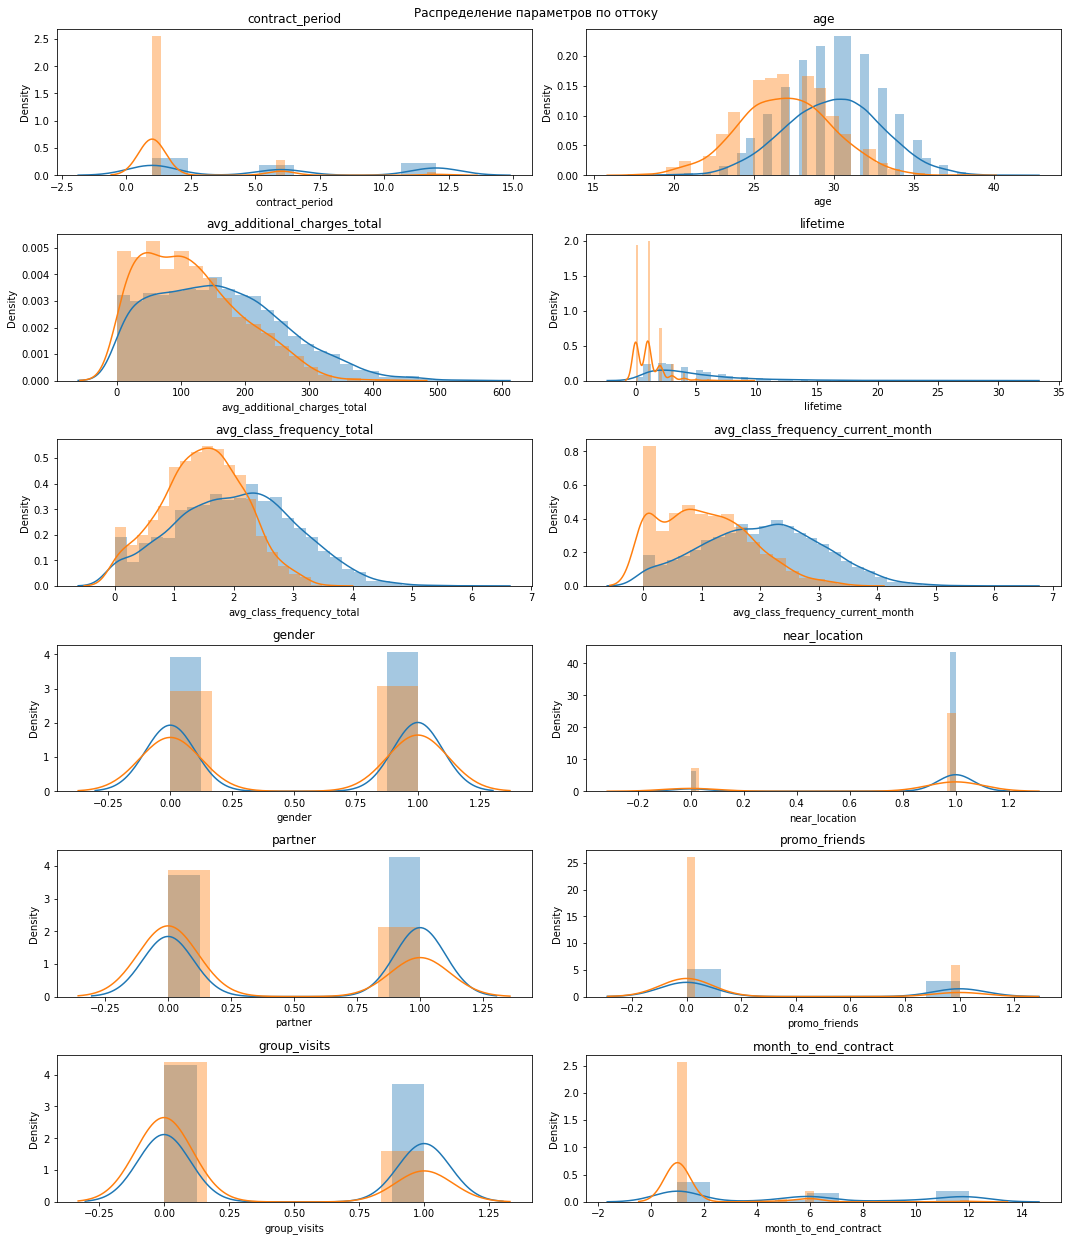

In [9]:
reserch = ['contract_period', 
           'age', 
           'avg_additional_charges_total', 
           'lifetime', 
           'avg_class_frequency_total', 
           'avg_class_frequency_current_month',
           'gender',
           'near_location',
           'partner',
           'promo_friends',
           'group_visits',
           'month_to_end_contract'
          ]
col_count, row_count = 2,7
plt.figure(figsize = (15,20))
for i, j in enumerate(reserch):
    for churn in gym['churn'].unique():
        current = gym.query('churn == @churn')
        sns.distplot(current[j],
                   ax = plt.subplot(row_count, col_count, i+1))
        plt.title(j)
        
plt.suptitle('Распределение параметров по оттоку')
plt.tight_layout()

**Таким образом, можно сделать вывод, что:**
- клиенты в оттоке чаще посещали фитнес-центр, чем оставшиеся клиенты (2 раза), 
- имели абонемент на больший срок (6 мес),
- их средний возраст - 30 лет, 
- чаще посещали групповые занятия.

#### Постройте матрицу корреляций и отобразите её.

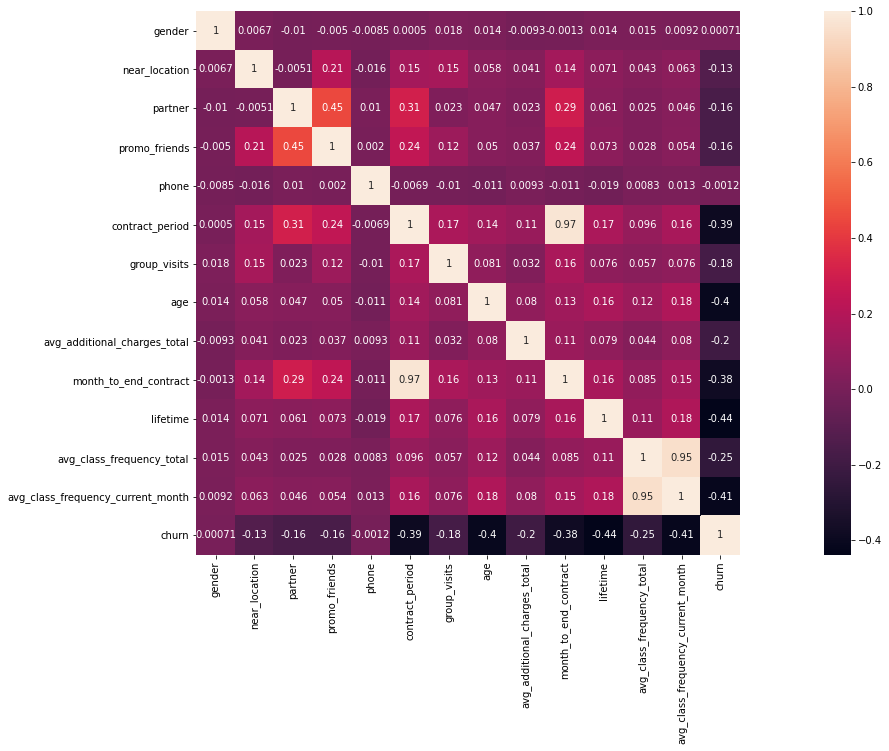

In [10]:
#построим и отрисуем матрицу корреляций
cm = gym.corr() #вычисляем матрицу корреляций

#нарисуем тепловую карту с подписями для матрицы корреляций
plt.figure(figsize = (30,10))
sns.heatmap(cm, annot=True, square=True)
plt.show()

**Вывод:** 


Сильно коррелируют между собой признаки:
1. Partner и Promo_friends,
2. Month_to_end_contract и Contract_period
3. Avg_class_frequency_current_month и Avg_class_frequency_total.

Для дальнейшего анализы исключим по одному из пары коррелирующих признаков.

In [11]:
gym.drop(['partner', 'month_to_end_contract', 'avg_class_frequency_current_month'], axis=1, inplace=True)
gym.head()

,gender,near_location,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn
0,1,1,1,0,6,1,29,14.227470,3,0.020398,0
1,0,1,0,1,12,1,31,113.202938,7,1.922936,0
2,0,1,0,1,1,0,28,129.448479,2,1.859098,0
3,0,1,1,1,12,1,33,62.669863,2,3.205633,0
4,1,1,1,1,1,0,26,198.362265,3,1.113884,0


### Построение модели прогнозирования оттока клиентов.

#### Постройте модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце:
1. Разбейте данные на обучающую и валидационную выборку функцией train_test_split().
2. Обучите модель на train-выборке двумя способами:
   - логистической регрессией,
   - случайным лесом.
3. Оцените метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравните по ним модели. Какая модель показала себя лучше на основании метрик?

Не забудьте указать параметр random_state при разделении выборки и задании алгоритма.

In [12]:
#разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = gym.drop('churn', axis = 1) #ваш код здесь
y = gym['churn'] #ваш код здесь

In [13]:
#разделяем модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

In [14]:
# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

In [15]:
# ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ 

# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# Преобразуйте обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state=0)
# обучим модель
lr_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]
# выведем все метрики
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)


Метрики для модели логистической регрессии:
	Accuracy: 0.90
	Precision: 0.78
	Recall: 0.81
	F1: 0.80
	ROC_AUC: 0.95


In [16]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) # Ваш код здесь
# обучим модель случайного леса
rf_model.fit(X_train, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test)  # Ваш код здесь
rf_probabilities = rf_model.predict_proba(X_test)[:, 1] # Ваш код здесь
# выведем все метрики
print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities, 
    title='Метрики для модели случайного леса:'
)

Метрики для модели случайного леса:
	Accuracy: 0.90
	Precision: 0.80
	Recall: 0.76
	F1: 0.78
	ROC_AUC: 0.94


**Вывод:** На основании метрик модели показали себя практически одинаково, ROC_AUC у логистической регрессии равен 0,95, а у случайного леса 0,94. 

### Кластеризация клиентов.

#### Стандартизируйте данные.

In [17]:
# стандартизируем данные
sc = StandardScaler()
x_sc = sc.fit_transform(gym)

#### Постройте матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуйте дендрограмму. На основании полученного графика предположите, какое количество кластеров можно выделить.


In [18]:
linked = linkage(x_sc, method = 'ward') 

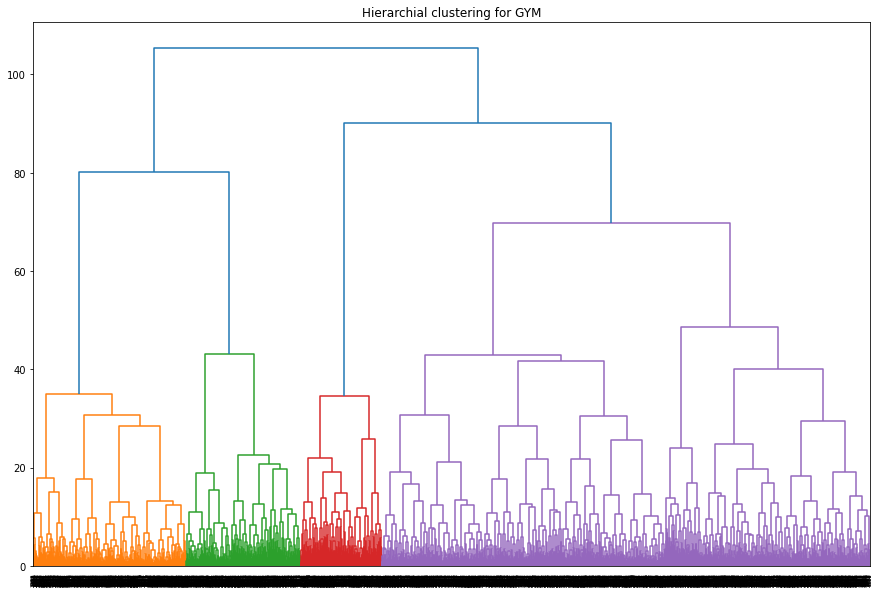

In [19]:
#визуализируем дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show() 

**Вывод:** На основании полученного графика выделяем 5 кластеров.

#### Обучите модель кластеризации на основании алгоритма K-Means и спрогнозируйте кластеры клиентов. Договоримся за число кластеров принять n=5.

In [20]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 2)
labels = km.fit_predict(x_sc)

#### Посмотрите на средние значения признаков для кластеров. Можно ли сразу что-то заметить?

In [21]:
# сохраняем метки кластера в поле нашего датасета
gym['cluster'] = labels

In [22]:
# выводим статистику по средним значениям наших признаков по кластеру
clusters = gym.groupby(['cluster']).mean()
clusters

,gender,near_location,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn
cluster,,,,,,,,,,,
0,0.507009,1.000000,0.197819,1.0,2.261682,0.445483,30.058411,158.704412,4.707165,2.031671,0.000779
1,0.512548,0.995174,0.626448,1.0,10.621622,0.546332,29.912162,160.952107,4.746139,2.041969,0.002896
2,0.514325,1.000000,0.229195,1.0,1.743520,0.293315,26.927694,114.994811,0.976808,1.476475,0.994543
3,0.499109,0.000000,0.080214,1.0,3.021390,0.233512,28.709447,137.783440,3.032086,1.771751,0.401070
4,0.523316,0.862694,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.854211,0.266839


#### Постройте распределения признаков для кластеров. Можно ли что-то заметить по ним?

In [23]:
# определим функцию отрисовки графиков попарных признаков для кластеров
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        df[x_name], df[y_name], hue=df[cluster_name], palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()


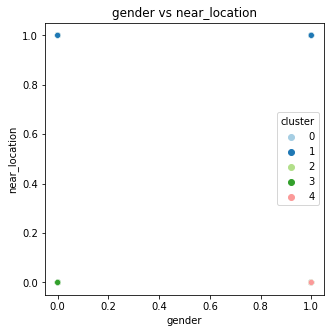

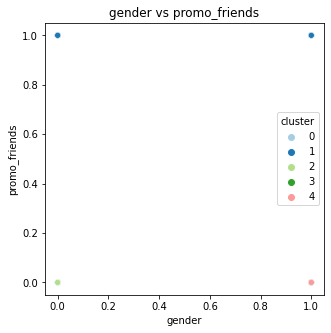

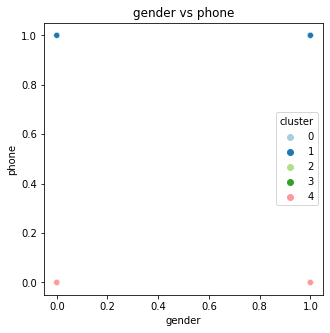

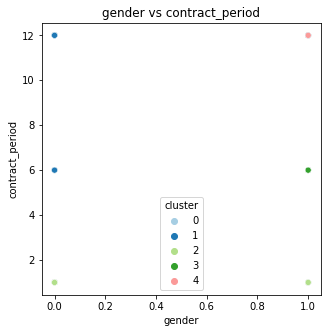

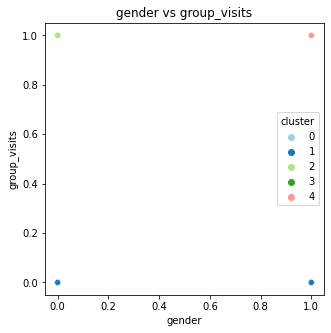

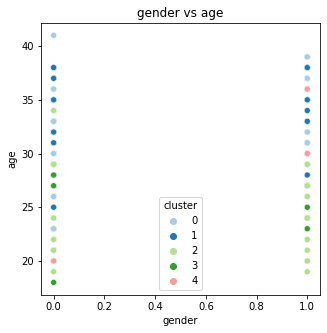

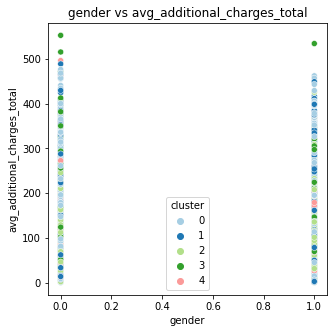

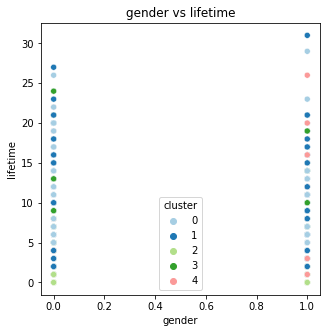

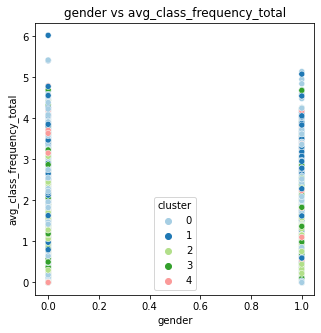

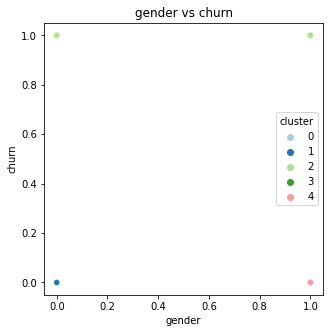

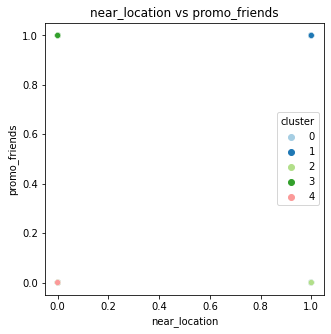

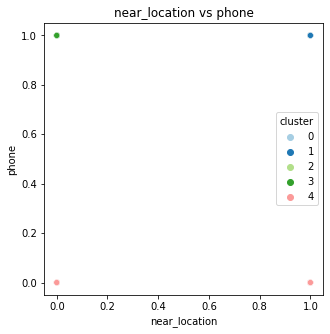

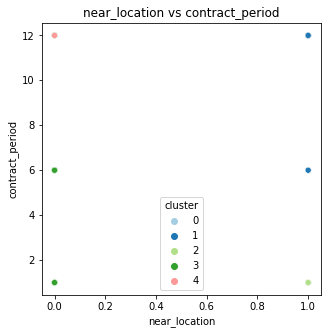

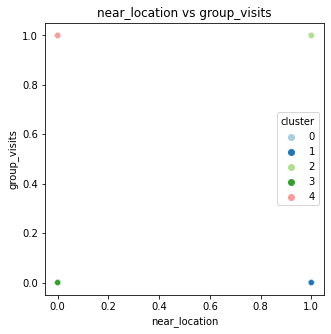

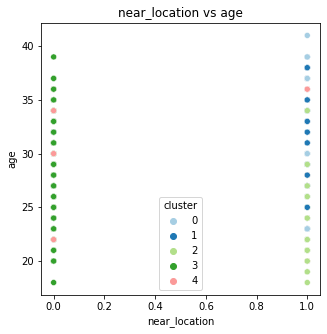

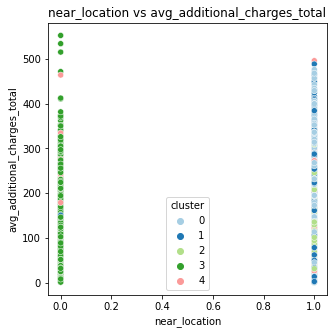

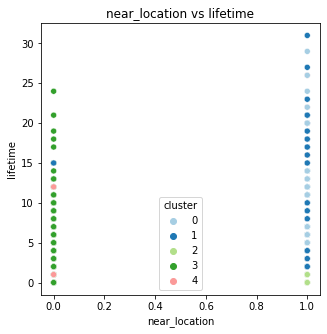

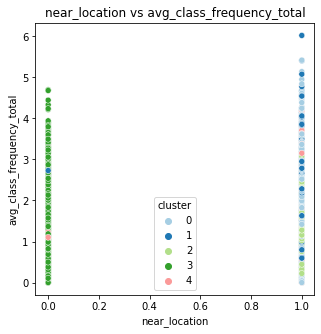

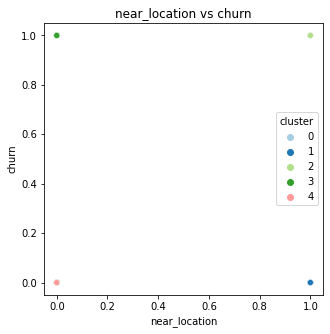

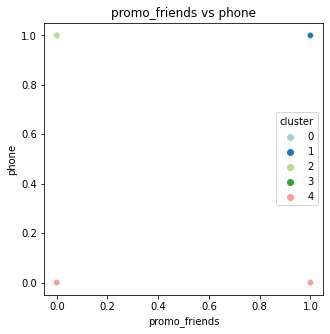

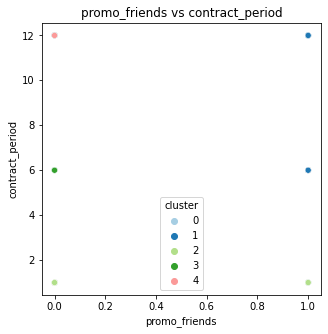

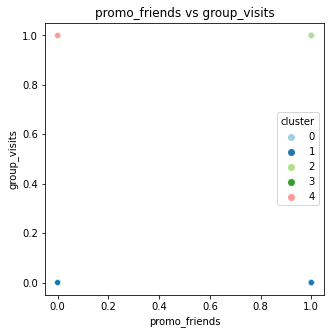

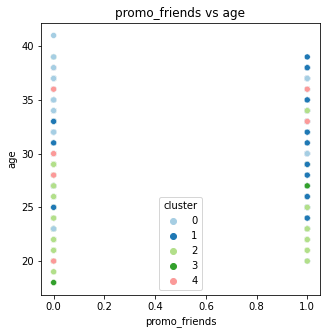

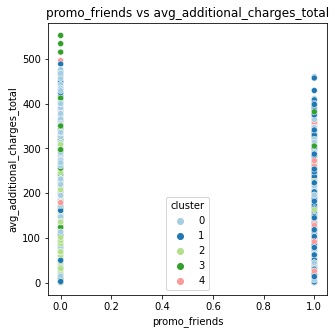

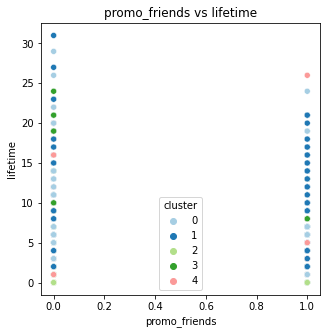

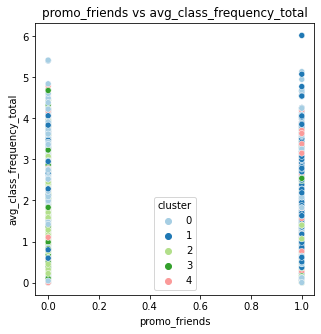

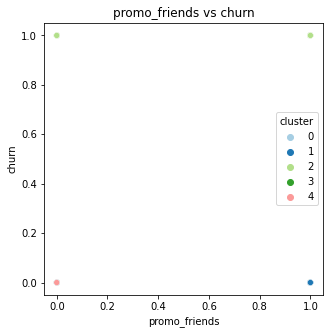

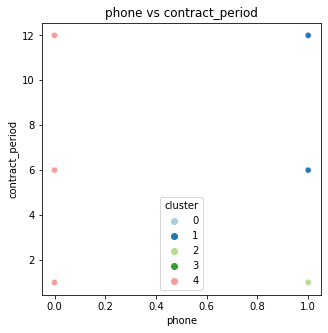

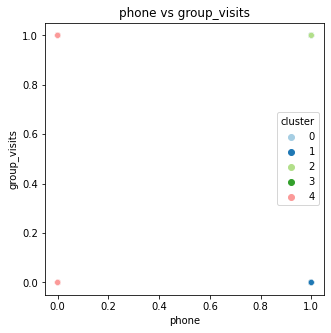

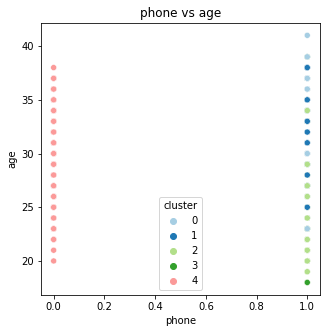

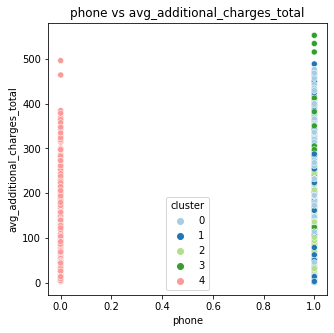

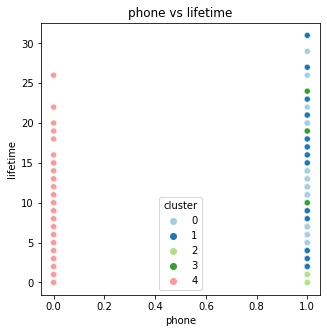

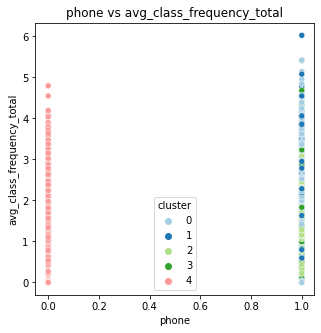

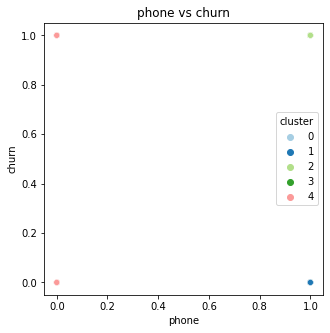

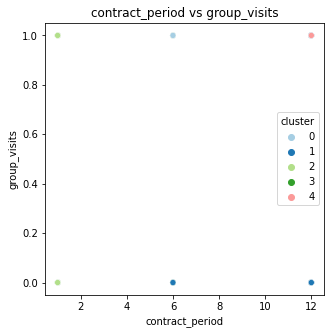

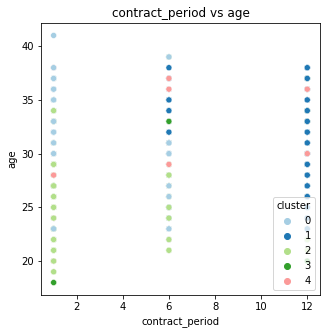

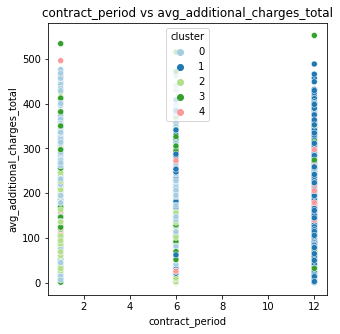

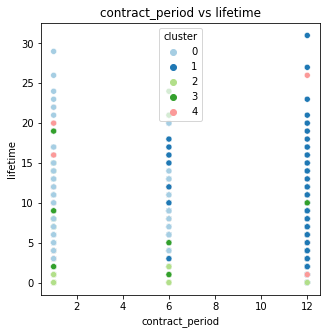

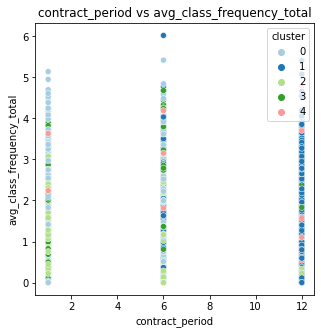

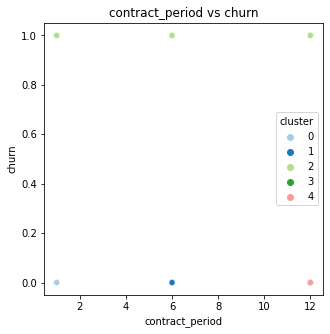

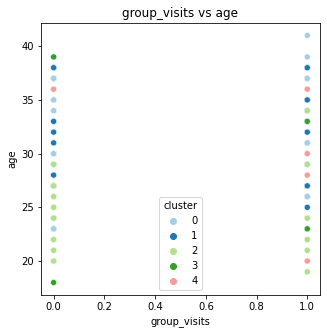

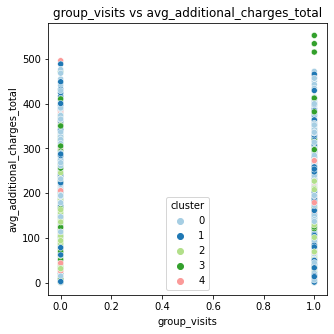

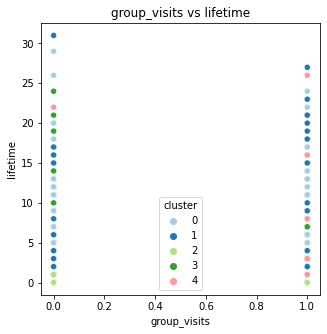

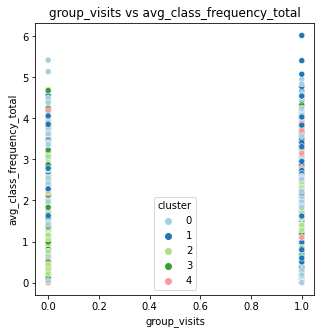

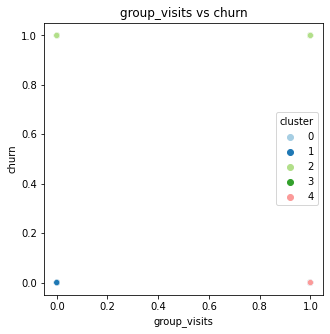

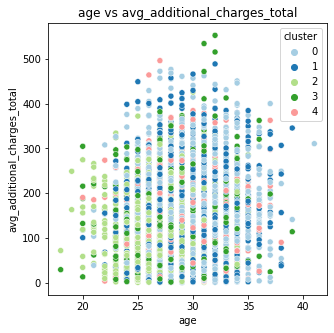

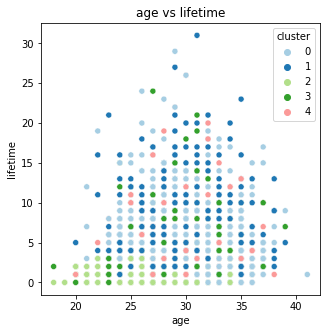

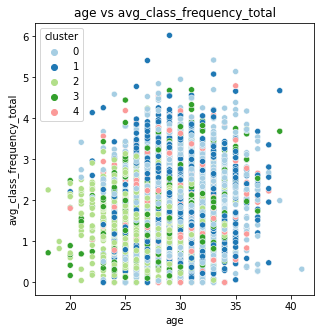

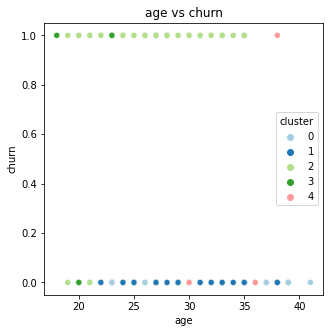

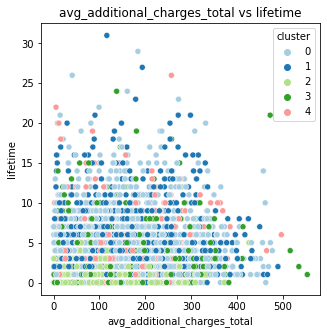

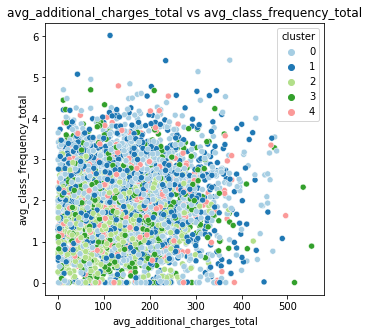

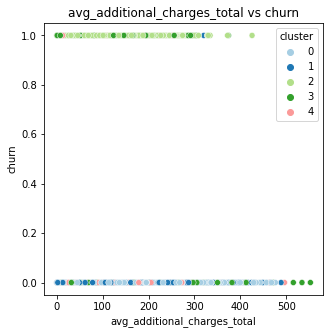

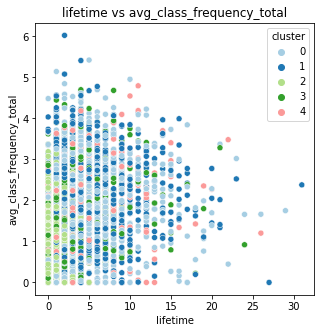

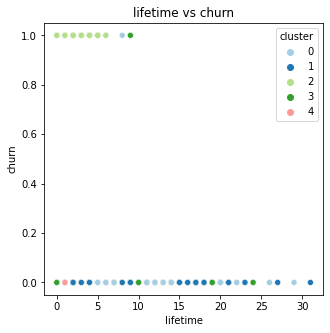

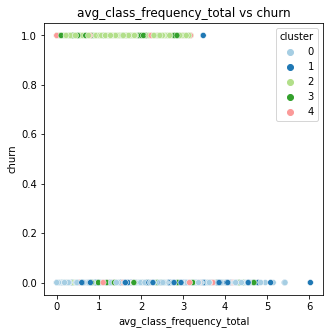

In [24]:
# отрисуем графики для попарных сочетаний признаков с разметкой по кластерам
col_pairs = list(itertools.combinations(gym.drop('cluster', axis=1).columns, 2))
for pair in col_pairs:
    show_clusters_on_plot(gym, pair[0], pair[1], 'cluster')

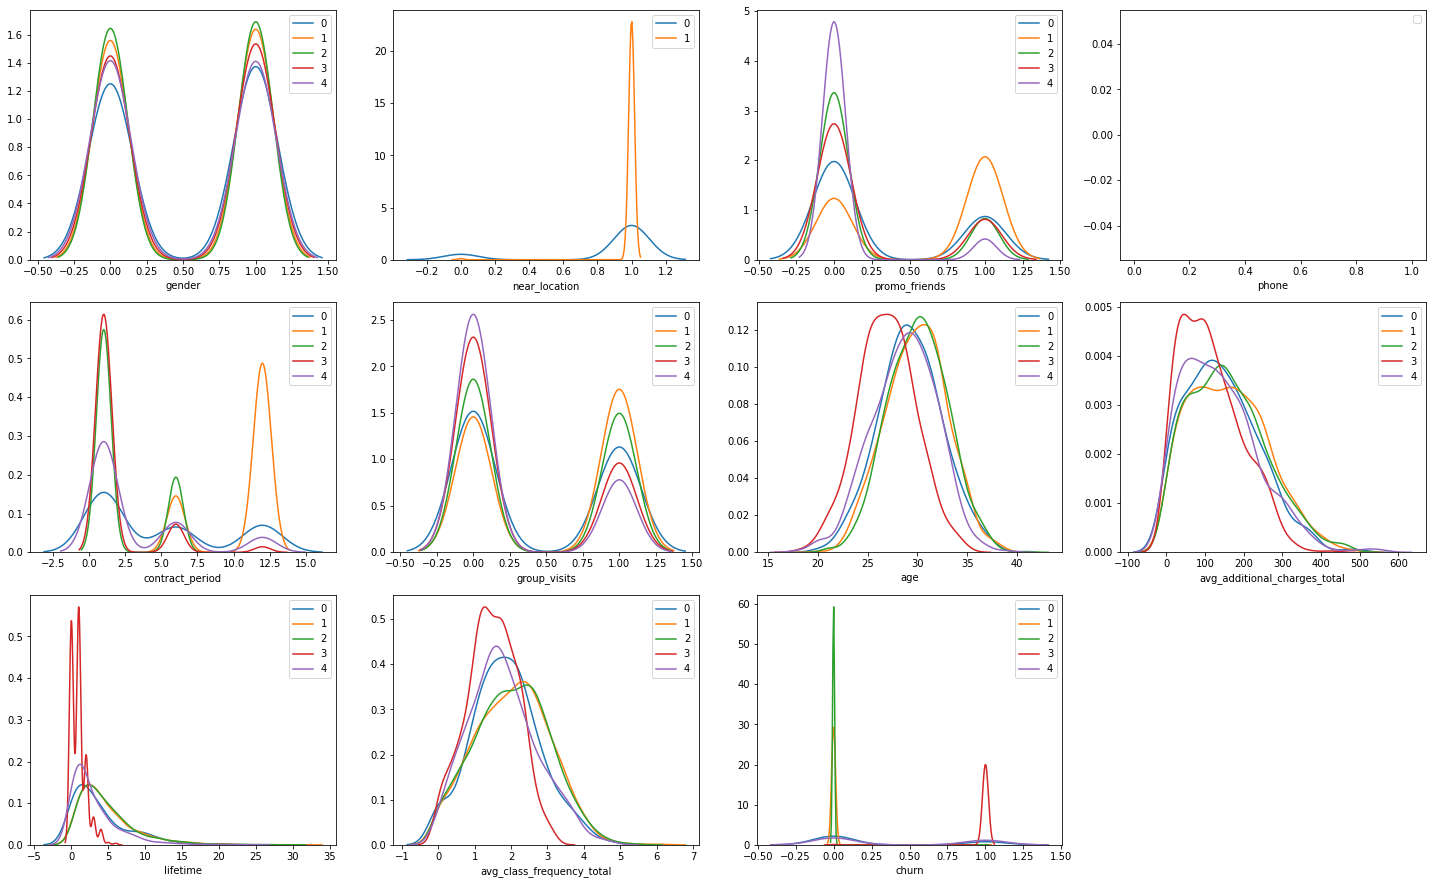

In [25]:
# построим распределения признаков для кластеров
plt.figure(figsize=(20,16))
params = gym.columns.drop('cluster')
for i, param in enumerate(params):
    plt.subplot(4,4,i+1)
    for cluster in gym['cluster'].unique():
        sns.distplot(gym[gym['cluster'] == cluster][param], kde = True, hist=False)
    plt.xlabel(param)
    plt.legend(['0', '1', '2', '3', '4'])
    plt.ylabel('')
    plt.tight_layout()

#### Для каждого полученного кластера посчитайте долю оттока (методом groupby()). Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?

In [26]:
clusters = gym.groupby(['cluster']).mean()
clusters

,gender,near_location,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn
cluster,,,,,,,,,,,
0,0.507009,1.000000,0.197819,1.0,2.261682,0.445483,30.058411,158.704412,4.707165,2.031671,0.000779
1,0.512548,0.995174,0.626448,1.0,10.621622,0.546332,29.912162,160.952107,4.746139,2.041969,0.002896
2,0.514325,1.000000,0.229195,1.0,1.743520,0.293315,26.927694,114.994811,0.976808,1.476475,0.994543
3,0.499109,0.000000,0.080214,1.0,3.021390,0.233512,28.709447,137.783440,3.032086,1.771751,0.401070
4,0.523316,0.862694,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.854211,0.266839


**Вывод:** Доля оттока в полученных кластерах разная. Наиболее склонен к оттоку кластеры "0" и "1". Самый надежный кластер "2". Средние кластеры с вероятностью оттока 25-40% - кластеры "4" и "3" соответственно.

#### Общие выводы по кластеризации клиентов: 
- Кластер 0: мужчин и женщин поравну, живут/работают рядом с фитнес-центром, в 19% случаев пришли по промокоду от знакомого, длительность текущего действующего абонемента в среднем 2 мес, в 45% случаев посещают групповые занятия, средний возраст - 30 лет, суммарная выручка от других услуг фитнес-центра в среднем 160 у.е., с момента первого обращения в фитнес-центр прошло 5 мес, средняя частота посещений в неделю - 2 раза, отток с вероятностью почти 100%. 


- Кластер 1: мужчин и женщин поравну, живут/работают рядом с фитнес-центром, в 63% случаев пришли по промокоду от знакомого, длительность текущего действующего абонемента в среднем 10 мес, в 55% случаев посещают групповые занятия, средний возраст - 30 лет, суммарная выручка от других услуг фитнес-центра в среднем 160 у.е., с момента первого обращения в фитнес-центр прошло 5 мес, средняя частота посещений в неделю - 2 раза, отток с вероятностью почти 100%. 


- Кластер 2: мужчин и женщин поравну, живут/работают рядом с фитнес-центром, в 23% случаев пришли по промокоду от знакомого, длительность текущего действующего абонемента в среднем 2 мес, в 30% случаев посещают групповые занятия, средний возраст - 27 лет, суммарная выручка от других услуг фитнес-центра в среднем 115 у.е., с момента первого обращения в фитнес-центр прошел 1 мес, средняя частота посещений в неделю - 1-2 раза, отток с вероятностью меньше 1%. 


- Кластер 3: мужчин и женщин поравну, живут/работают НЕ рядом с фитнес-центром, пришли НЕ по промокоду от знакомого, длительность текущего действующего абонемента в среднем 3 мес, в 23% случаев посещают групповые занятия, средний возраст - 29 лет, суммарная выручка от других услуг фитнес-центра в среднем 138 у.е., с момента первого обращения в фитнес-центр прошло 3 мес, средняя частота посещений в неделю - 1-2 раза, отток с вероятностью 40%. 


- Кластер 4: мужчин и женщин поравну, живут/работают в основном рядом с фитнес-центром, в 30% случаев пришли по промокоду от знакомого, длительность текущего действующего абонемента в среднем 5 мес, в 42% случаев посещают групповые занятия, средний возраст - 29 лет, суммарная выручка от других услуг фитнес-центра в среднем 144 у.е., с момента первого обращения в фитнес-центр прошло 4 мес, средняя частота посещений в неделю - 2 раза, отток с вероятностью 27%. 

### Общие выводы и рекомендации. 

Сформулируйте основные выводы и предложите рекомендации для стратегии взаимодействия с клиентами и их удержания.

Не описывайте стратегию детально: достаточно 3-4 важных принципов и примеров их реализации в виде определённых маркетинговых действий.

#### Общие выводы:
1. Среди клиентов фитнес-центра мужчин и женщин примерно поравну. Пол не влияет на отток. 
2. У 85% посетителей фитнес-центра рядом находится дом или работа. Расположение клуба не влияет на отток. 
3. Примерно 30% клиентов от общего кол-ва клиентов использовали промо-код от знакомого при оплате первого абонемента. Этот признак также не влияет на отток. 
4. Почти все клиенты указали номер телефона.
5. Средняя длительность текущего действующего абонемента - 5 месяцев. Можно заметить, что у клиентов, у котрых абонемент на бОльший срок - вероятность оттока у них также выше, а клиенты у которых абонемент на 1 мес. - более надежны. 
6. Меньше половины клиентов посещают групповые занятия. Причем те, кто посещают - более склонны к оттоку. 
7. Среднее время с момента первого обращения в фитнес-центр - 3,7 мес. Также прослеживается закономерность, что чем дольше человек является клиентом фитнес - центра, тем больше вероятность его оттока, а те, кто пришел недавно - с меньшей вероятностью уйдут. 
8. Средняя частота посещений в неделю 1-2 раза. Этот признак на отток не влияет.
9. Средний возраст клиентов в оттоке - 30 лет, у клиентов, которые остались в центре - 27 лет.


#### Рекомендации: 
Можно зметить, что "старенькие клиенты" чаще уходят в отток, возможно им становится скучно/устают и тд. Для их удержания:
1. Запустить реферальную программу - Для удержания клиентов важно дать им мотивацию приводить в клуб своих друзей. Достигнуть поставленных целей проще с партнером, чем в одиночку. Создать стимул приглашать в клуб новых членов можно при помощи бонусов. Например, пакета персональных тренировок по специальной цене за определенное количество приглашенных участников.

2. Используйте возможности CRM - Просто напомните участникам о выгоде посещения тренировок или возможных привилегиях, которые они упускают. 

3. Поощряйте активных клиентов - Если в вашем клубе занимаются «постояльцы», отблагодарите их бонусами. Например, подарочные карты постоянных участников или скидки на продление абонемента.

4. Организуйте профессиональные соревнования. 